# Estimating the Oregon Health Insurance Experiment Effects

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Part 1 - Introduction

### Project Overview

In this project, I analyze the curated Oregon Health Insurance Experiment (OHIE) public-use data. The full dataset can be accessed via this [link](https://data.nber.org/oregon/index.html). 

I am in particular interested in estimating the causal effects of expanding access to public health insurance (here Medicaid) on the number of doctor visits later on. 

To do causal inference, I adopt the cutting-edge machine learning augmented regression strategy, in addition to linear regression. Specifically, I implement and compare the following three broad sets of models: 
* linear regression (with or without important controls), 
* post-double selection lasso (PDS Lasso), 
* Double/Debiased machine learning (DML) (with Ridge)

It is primarily based in Python and uses multiple libraries, including statsmodels, sklearn, pandas, seaborn and more. 

### Project Background

**_What is the Oregon Health Insurance Experiment (OHIE)?_** 

Public health insurance is crucial to our society. OHIE is an innovative randomized control trial designed to expand the access to uninsured low-income adults in Oregon, US, starting the year 2008. Specifically, the randomization process involved a lottery where names were randomly drawn from eligible individuals. Those who got selected (and their household members) would be allowed to apply for the Medicaid program, a public health program jointly administered by the US states and the federal government. 

**_What effects does OHIE have on average?_** 

OHIE offers a unique opportunity to study the program effects on various health and financial outcomes. There is a list of papers that evaluated OHIE's impacts. According to their findings, Medicaid coverage resulted in higher utilization of healthcare services, including preventive care and emergency department visits, as well as reduced financial stress, depression rates, and improved self-reported health. However, they did not find evidence that Medicaid coverage improved physical health or had an impact on employment. More information about these results can be found [here](https://data.nber.org/oregon/index.html). 

In this project, I will focus on a single healthcare use outcome: the number of doctor visits in the past 12 months. Previous research suggests that the estimated sign of the treatment effect on this outcome is likely to be positive. 

### Dataset Information

The curated dataset is presented in a .csv file, where each row shows the records of eligible individuals and each column presents their treatment status, healthcare usage, and other descriptive features.  

In [4]:
# load the data
oregonhie = pd.read_csv('https://github.com/Mixtape-Sessions/Machine-Learning/blob/main/Labs/data/oregon_hie_table5.csv?raw=true')
oregonhie

,household_id,treatment,weight,rx_any,rx_num,doc_any,doc_num,er_any,er_num,hosp_any,...,dddnumhh_li_2,dddnumhh_li_3,ddddraXnum_2_2,ddddraXnum_2_3,ddddraXnum_3_2,ddddraXnum_3_3,ddddraXnum_4_2,ddddraXnum_5_2,ddddraXnum_6_2,ddddraXnum_7_2
0,100001,1,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100002,1,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,100005,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,1,1.0,1.0,6.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,102094,0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23736,174905,0,1.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
23737,174910,0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
23738,174911,1,1.0,1.0,4.0,1.0,2.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
23739,174917,0,1.0,1.0,11.0,1.0,5.0,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# restrict health outcome to the number of doctor visits (i.e., doc_num)
regvarnames = ['household_id','doc_num','treatment']+[col for col in oregonhie if col.startswith('ddd')]
df = oregonhie[regvarnames]

In [6]:
# drop entries with missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23441 entries, 0 to 23740
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   household_id    23441 non-null  int64  
 1   doc_num         23441 non-null  float64
 2   treatment       23441 non-null  int64  
 3   ddddraw_sur_2   23441 non-null  int64  
 4   ddddraw_sur_3   23441 non-null  int64  
 5   ddddraw_sur_4   23441 non-null  int64  
 6   ddddraw_sur_5   23441 non-null  int64  
 7   ddddraw_sur_6   23441 non-null  int64  
 8   ddddraw_sur_7   23441 non-null  int64  
 9   dddnumhh_li_2   23441 non-null  int64  
 10  dddnumhh_li_3   23441 non-null  int64  
 11  ddddraXnum_2_2  23441 non-null  int64  
 12  ddddraXnum_2_3  23441 non-null  int64  
 13  ddddraXnum_3_2  23441 non-null  int64  
 14  ddddraXnum_3_3  23441 non-null  int64  
 15  ddddraXnum_4_2  23441 non-null  int64  
 16  ddddraXnum_5_2  23441 non-null  int64  
 17  ddddraXnum_6_2  23441 non-null 

In [7]:
df.head()

,household_id,doc_num,treatment,ddddraw_sur_2,ddddraw_sur_3,ddddraw_sur_4,ddddraw_sur_5,ddddraw_sur_6,ddddraw_sur_7,dddnumhh_li_2,dddnumhh_li_3,ddddraXnum_2_2,ddddraXnum_2_3,ddddraXnum_3_2,ddddraXnum_3_3,ddddraXnum_4_2,ddddraXnum_5_2,ddddraXnum_6_2,ddddraXnum_7_2
0,100001,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,100002,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,100005,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,100006,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,102094,0.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0


For this project, I restrict the healthcare usage to the number of doctor visits and drop all the other post-treatment outcomes, such as the number of ER visits and hospitalizations. I also check and drop any missing values in the remaining features. 

In the end, the data frame contains 19 numerical features and 23740 individual records. 

The key dependent and independent variables are the number of doctor visits in the past 12 months (denoted by **'doc_num'**), as well as treatment indicator for being selected in the lottery (denoted by **'treatment'**). 

Other features include:
* household_id: household identifier
* ddddraw_sur_2 to *_7: dummy variables indicating the specific wave of the 12-month follow-up survey (ddddraw_sur_1 is dropped to avoid perfect multicollinearity)
* dddnumhh_li_2 & dddnumhh_li_3: dummy variables showing the number of people in the household on the lottery list (with the base set as dddnumhh_li_1 and dropped)
* ddddraXnum_#_#: interaction terms of the survey wave dummies and the household size dummies on the lottery list

In [8]:
# check the number of duplicates and review them
duplicates_count = df.duplicated().sum()
print(duplicates_count) 

duplicates = df[df.duplicated(keep=False)].sort_values(by='household_id')
duplicates.head(10)

950


,household_id,doc_num,treatment,ddddraw_sur_2,ddddraw_sur_3,ddddraw_sur_4,ddddraw_sur_5,ddddraw_sur_6,ddddraw_sur_7,dddnumhh_li_2,dddnumhh_li_3,ddddraXnum_2_2,ddddraXnum_2_3,ddddraXnum_3_2,ddddraXnum_3_3,ddddraXnum_4_2,ddddraXnum_5_2,ddddraXnum_6_2,ddddraXnum_7_2
1195,104487,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1449,104487,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1370,104489,0.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1451,104489,0.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1736,105429,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1471,105429,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1792,105571,2.0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1483,105571,2.0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
737,105787,2.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1848,105787,2.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


For duplicates, it is interesting to see multiple individuals share the same  household id, treatment status, and the number of doctor visits. 

For example, for household_id 104487, there are two individuals on record, both of whom were treated and surveyed in the wave 4. It is also consistent with the value of dddnumhh_li_2 being 1 (while dddnumhh_li_3 being 0).

I argue that this should NOT be considered a data abnormality but rather something important to consider while modeling. According to the experiment design, if an individual was selected for the study, their entire household was considered eligible for insurance. In other words, the treatment is correlated with the household size.

To further clarify this point, I will formally test the association between the treatment status and household size in the EDA section, as well as analyze both linear regression with and without family size controls in the model section. 

## Part II - Explanatory Descriptive Analysis (brief)

In this part, I check both univariate distribution and bivaraite correlations. 

Specifically, I first examine all the numerical features using the .describe() method; I then zoom in on the key health outcome and look for any interesting patterns through visualization. I last check for significant associations between the treatment status and other included features.

### Check univariate distribution

In [9]:
df = df.drop(['household_id'], axis=1)

df.describe()

,doc_num,treatment,ddddraw_sur_2,ddddraw_sur_3,ddddraw_sur_4,ddddraw_sur_5,ddddraw_sur_6,ddddraw_sur_7,dddnumhh_li_2,dddnumhh_li_3,ddddraXnum_2_2,ddddraXnum_2_3,ddddraXnum_3_2,ddddraXnum_3_3,ddddraXnum_4_2,ddddraXnum_5_2,ddddraXnum_6_2,ddddraXnum_7_2
count,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000,23441.000000
mean,1.949106,0.497035,0.113220,0.112367,0.140011,0.141163,0.205025,0.173073,0.295337,0.002474,0.039247,0.001109,0.041892,0.000768,0.048078,0.049358,0.068555,0.006143
std,2.923004,0.500002,0.316869,0.315824,0.347006,0.348197,0.403729,0.378318,0.456204,0.049682,0.194187,0.033286,0.200348,0.027701,0.213936,0.216619,0.252701,0.078138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Since most features are dummy variables, their mean can be quite informative. 

For example, the mean of the treatment indicator equals 0.497, which is almost the same as 0.5. It suggests that about half of the individuals were assigned to the treatment group and the other half to the control group. Each of the 7 survey waves roughly draws individuals at the same rate, ranging from 10% to 20%.

Looking at the number of people in households on the lottery list, it is evident that most individuals do not share household members. About 30% of individuals have two people from their household on the list, and only 0.2% have three people on the list.

<AxesSubplot:xlabel='doc_num', ylabel='Density'>

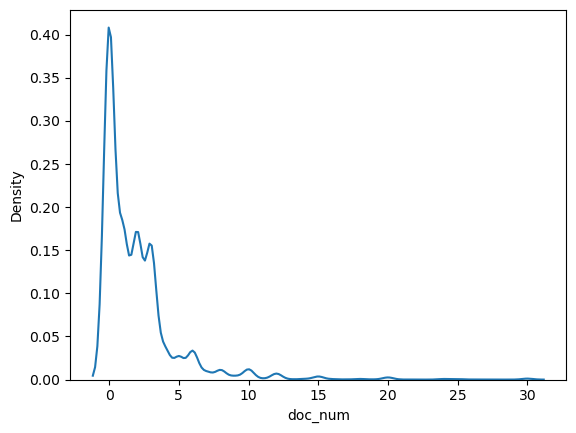

In [10]:
# visualize the outcome distribution
sns.kdeplot(x='doc_num', data=df)

The percentage of zero doctor visits in the past year: 0.397
The percentage of zero doctor visits in the past year: 0.157
The percentage of zero doctor visits in the past year: 0.158
The percentage of zero doctor visits in the past year: 0.148


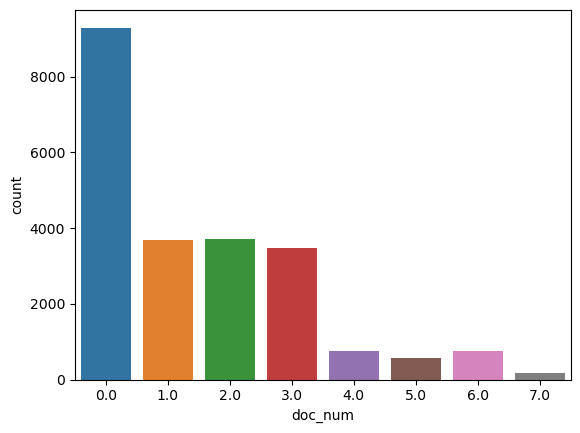

In [11]:
df1 = df.copy()

for col in ['doc_num']:
    q75 = df1[col].quantile(0.75)
    q25 = df1[col].quantile(0.25)
    intr_qr = q75 - q25
    upper = q75 + (1.5*intr_qr)
    lower = q25 - (1.5*intr_qr)
    df1 = df1[(df1[col] > lower) & (df1[col] < upper)]
    
sns.countplot(x='doc_num', data=df1)

print("The percentage of zero doctor visits in the past year: {:.3f}".format(df['doc_num'].value_counts(normalize=True)[0.0]))
print("The percentage of zero doctor visits in the past year: {:.3f}".format(df['doc_num'].value_counts(normalize=True)[1.0]))
print("The percentage of zero doctor visits in the past year: {:.3f}".format(df['doc_num'].value_counts(normalize=True)[2.0]))
print("The percentage of zero doctor visits in the past year: {:.3f}".format(df['doc_num'].value_counts(normalize=True)[3.0]))

I then zoom in on the key health outcome, namely the number of doctor visits in the past 12 months. Its distribution is right-skewed, with a few large values lying on the right, while the majority of the data values are clustered between 0 to 5 visits. 

Interestingly, around 40% of individuals didn't visit a doctor in the past year. However, 15% did visit a doctor between 1 and 3 times. I leave the variable unchanged.

### Check bivariate relationship

For bivariate relationships, I first visualize the distributions of the number of doctor visits across treatment and control group using a countplot. 

There is evidence that the treatment group tends to visit a doctor more frequently in the past year than the control group, as its distribution is shifted towards the right. The association is also supported by the very small p-value of the Chi-square test.

The Chi-Square value is 107.554.
The p-value is 0.000.


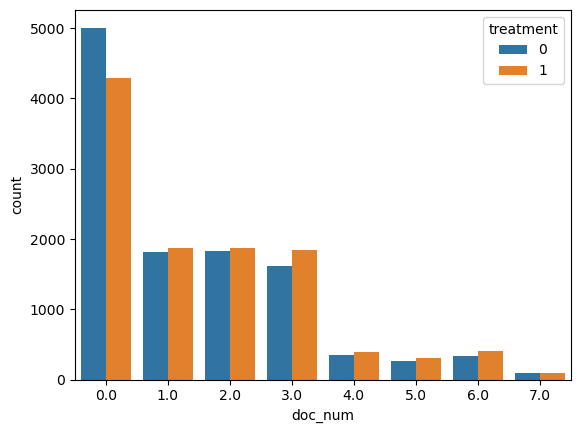

In [12]:
sns.countplot(x='doc_num', hue='treatment', data=df, order=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])

cross_tab = pd.crosstab(index = df["treatment"], columns = df['doc_num'])
stat, p, dof, expected = stats.chi2_contingency(cross_tab)
print('The Chi-Square value is {:.3f}.\nThe p-value is {:.3f}.'.format(stat,p))

I also look at the association between the treatment assignment and the household sizes (as well as the survey waves) using barplots as well as performing Chi-square test.

The barplot and Chi-square test results are consistent with each other, suggesting that the household sizes are indeed correlated with the treatment assignment. It confirms our initial thought when checking duplicates. Thus it is important to include them as control variables in the regression. 

Furthermore, the significant association between treatment status and survey waves makes a similar point, since they are also likely to be confounders that are correlated with both the treatment and the outcome. 

For simplicity, I only show the two tests using some of the household size and survey wave dummies; but the same process can be applied to the remaining variables.

The Chi-Square value is 207.070.
The p-value is 0.000.


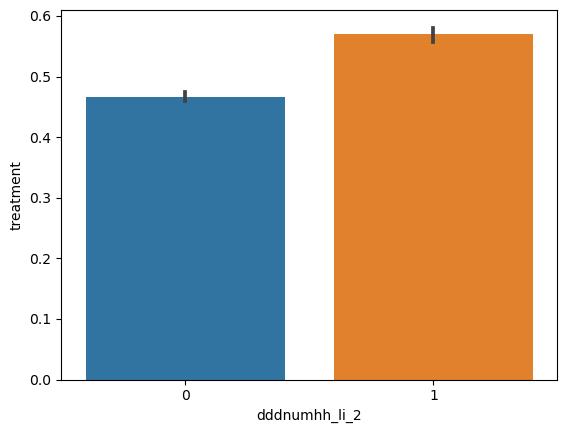

In [13]:
sns.barplot(x=df['dddnumhh_li_2'], y=df['treatment'])

cross_tab = pd.crosstab(index = df["treatment"], columns = df["dddnumhh_li_2"])
stat, p, dof, expected = stats.chi2_contingency(cross_tab)
print('The Chi-Square value is {:.3f}.\nThe p-value is {:.3f}.'.format(stat,p))

The Chi-Square value is 290.425.
The p-value is 0.000.


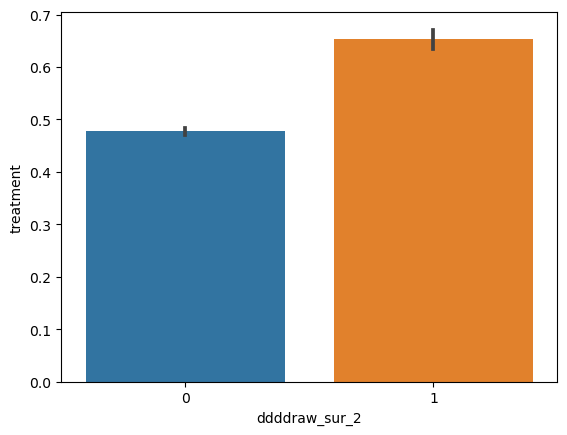

In [14]:
sns.barplot(x=df['ddddraw_sur_2'], y=df['treatment'])

cross_tab = pd.crosstab(index = df["treatment"], columns = df["ddddraw_sur_2"])
stat, p, dof, expected = stats.chi2_contingency(cross_tab)
print('The Chi-Square value is {:.3f}.\nThe p-value is {:.3f}.'.format(stat,p))

## Part III - Modeling

To estimate the causal experiment effects, I first perform the linear regression models, either with or without controls. The two estimates differ significantly, indicating the need for appropriate controls.

Second, I employ PDS Lasso to choose controls. The basic idea is to apply Lasso to identify the most relevant features in the two steps, which are then used to estimate causal effects through OLS regression. 

Third, I run Double ML with Ridge in both steps. Compared to PDS lasso, DML provides even more flexibility in how the potential control features enter for the key explanatory variable (and the outcome).

Finally, I compare the estimates from the four models and then conclude. 

In [15]:
# Define "menu" of regressors and target:
y = df[['doc_num']]
d = df[['treatment']]
X = df.drop(['doc_num','treatment'],axis=1)

### Model 1 - simple ols without controls

In [16]:
# running ols in sklearn (which does not return a p-value by default)
lm1 = linear_model.LinearRegression()
lm1.fit(d, y)

# OR run ols in statsmodel
rhs = sm.add_constant(d)
model = sm.OLS(y, rhs)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                doc_num   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     42.56
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           7.00e-11
Time:                        11:38:05   Log-Likelihood:                -58383.
No. Observations:               23441   AIC:                         1.168e+05
Df Residuals:                   23439   BIC:                         1.168e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8254      0.026     69.775      0.0

### Model 2 - simple ols with household size controls

In [17]:
X2 = df[['dddnumhh_li_2', 'dddnumhh_li_3']]
rhs = pd.concat([d, X2], axis=1)
lm2 = linear_model.LinearRegression()
lm2.fit(rhs, y)

rhs1 = sm.add_constant(rhs)
model = sm.OLS(y, rhs1)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                doc_num   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     47.27
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.90e-30
Time:                        11:38:05   Log-Likelihood:                -58338.
No. Observations:               23441   AIC:                         1.167e+05
Df Residuals:                   23437   BIC:                         1.167e+05
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.9234      0.029     67.013

### Model 3 - PDS lasso

Here is an overview of the step-by-step implementation for PDS lasso: 
1. Lasso Y on X, collect retained features in X
2. Lasso D on X, collect retained features in X
3. Regression Y on D, and the union of the retrained features in X from the first two steps

In my case, the lasso picked 14 out of 16 covariates.

In [18]:
# PDS Lasso step 1
lassoy = linear_model.LassoCV(max_iter=1000,normalize=True).fit(X, y)

                Lasso coefficients
ddddraw_sur_2             0.000000
ddddraw_sur_3             0.000000
ddddraw_sur_4             0.000000
ddddraw_sur_5             0.065584
ddddraw_sur_6            -0.000000
ddddraw_sur_7            -0.000000
dddnumhh_li_2            -0.300877
dddnumhh_li_3            -0.363181
ddddraXnum_2_2           -0.000000
ddddraXnum_2_3           -0.000000
ddddraXnum_3_2            0.000000
ddddraXnum_3_3           -0.000000
ddddraXnum_4_2            0.000000
ddddraXnum_5_2           -0.000000
ddddraXnum_6_2           -0.040655
ddddraXnum_7_2            0.000000


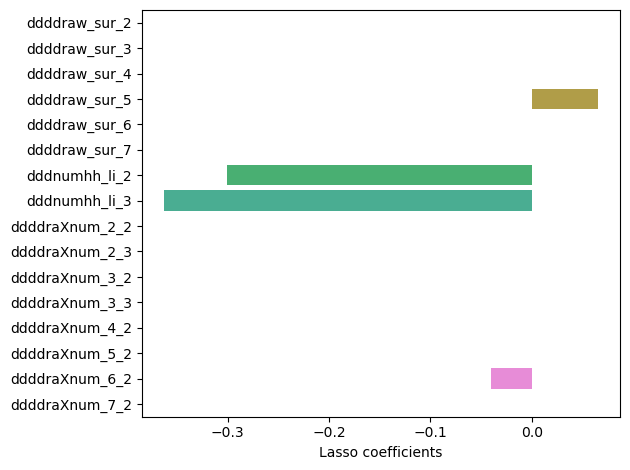

In [19]:
coefy = dict(zip(X.columns, lassoy.coef_))
coefy_df = pd.DataFrame.from_dict(coefy, orient='index').rename(columns={0: 'Lasso coefficients'})
print(coefy_df)

sns.barplot(data = coefy_df, 
            x = 'Lasso coefficients', 
            y = coefy_df.index)
plt.tight_layout()

                Lasso coefficients
ddddraw_sur_2             0.001403
ddddraw_sur_3             0.028605
ddddraw_sur_4            -0.155681
ddddraw_sur_5            -0.155802
ddddraw_sur_6            -0.176612
ddddraw_sur_7            -0.257285
dddnumhh_li_2             0.090532
dddnumhh_li_3             0.202592
ddddraXnum_2_2            0.045306
ddddraXnum_2_3            0.133983
ddddraXnum_3_2           -0.000000
ddddraXnum_3_3            0.029152
ddddraXnum_4_2            0.000000
ddddraXnum_5_2           -0.014912
ddddraXnum_6_2           -0.128347
ddddraXnum_7_2           -0.060600


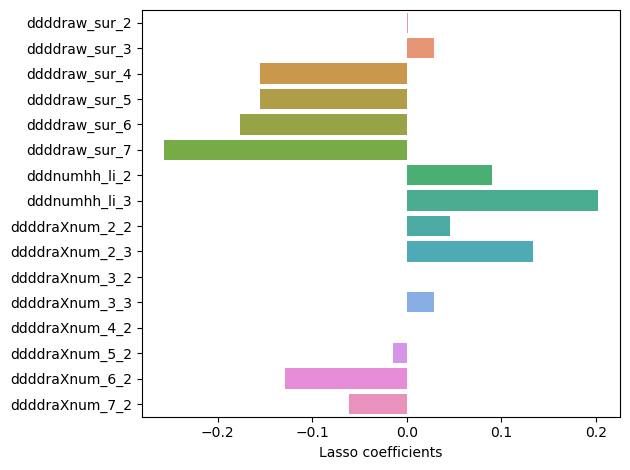

In [20]:
# PDS Lasso step 2
lassod = linear_model.LassoCV(max_iter=1000,normalize=True).fit(X, d)

coefd = dict(zip(X.columns, lassod.coef_))
coefd_df = pd.DataFrame.from_dict(coefd, orient='index').rename(columns={0: 'Lasso coefficients'})
print(coefd_df)

sns.barplot(data = coefd_df, 
            x ='Lasso coefficients', 
            y = coefd_df.index)
plt.tight_layout()

In [21]:
# PDS Lasso step 3
Xunion=X.iloc[:,(lassod.coef_!=0) + (lassoy.coef_!=0)]

rhs=pd.concat([d,Xunion],axis=1)
fullreg=linear_model.LinearRegression().fit(rhs,y)

rhs2 = sm.add_constant(rhs)
model = sm.OLS(y, rhs2)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                doc_num   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     11.38
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           2.36e-28
Time:                        11:38:06   Log-Likelihood:                -58331.
No. Observations:               23441   AIC:                         1.167e+05
Df Residuals:                   23425   BIC:                         1.168e+05
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.7855      0.063     28.

### Model 4 - Double ML with Ridge

Here is an overview of the step-by-step implementation for Double ML (with cross-fitting): 
1. Divide the sample into K folds
2. For each kth sample: \
    a. train a model to predict Y given X using the trained subsample \
    b. train a model to predict D given X using the (same) trained subsample \
    c. apply the two trained models in the test subsample to get the residuals of Y and D (by subtracting predicted values from the actual values)
3. Regress the Y residuals on the D residuals

In [22]:
# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X)

# initialize the model
ridgey = linear_model.RidgeCV(normalize=True).fit(X, y)
ridged = linear_model.RidgeCV(normalize=True).fit(X, d)

# initialize columns for residuals
yresid = y*0
dresid = d*0

# Now loop through each fold
ii=0
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  d_train, d_test = d.iloc[train_index,:], d.iloc[test_index,:]
  
  # Do DML thing
  # Ridge y on training folds:
  ridgey.fit(X_train, y_train)

  # but get residuals in test set
  yresid.iloc[test_index]=y_test-ridgey.predict(X_test)
  
  #Ridge d on training folds
  ridged.fit(X_train, d_train)

  #but get residuals in test set
  dresid.iloc[test_index,:]=d_test-ridged.predict(X_test)

# Regress resids
dmlreg1=linear_model.LinearRegression().fit(dresid,yresid)

rhs3 = sm.add_constant(dresid)
model = sm.OLS(yresid, rhs3)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                doc_num   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     55.29
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.07e-13
Time:                        11:38:06   Log-Likelihood:                -58344.
No. Observations:               23441   AIC:                         1.167e+05
Df Residuals:                   23439   BIC:                         1.167e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.019     -0.021      0.9

### Comparing program effects estimates from the four models

In summary, we found that the impact of the experiment on the number of doctor visits is positive and statistically significant at 1\% level. The estimates vary depending on the type of regression model used. 

Specifically, simple regression models without controls have the smallest impact, while those with household size controls have larger impact. The estimates from the two machine learning augmented regression strategies, PDS Lasso and Double ML, are the largest and very similar. 

In [23]:
# comparing the estimates from the four models
print("Model 1 Estimated experiment effect on number of doctor visits: {:.3f}".format(lm1.coef_[0][0]))
print("Model 2 Estimated experiment effect on number of doctor visits: {:.3f}".format(lm2.coef_[0][0]))
print("Model 3 Estimated experiment effect on number of doctor visits: {:.3f}".format(fullreg.coef_[0][0]))
print("Model 4 Estimated experiment effect on number of doctor visits: {:.3f}".format(dmlreg1.coef_[0][0]))

Model 1 Estimated experiment effect on number of doctor visits: 0.249
Model 2 Estimated experiment effect on number of doctor visits: 0.286
Model 3 Estimated experiment effect on number of doctor visits: 0.296
Model 4 Estimated experiment effect on number of doctor visits: 0.294


## Conclusion

Overall, this project studies the causal effects of a large-scale public health insurance expansion program in the US called OHIE on healthcare usage. It is important to understand its impact from both policy and research perspectives. For one, the signs of program effects are not clear based on theory and thus require empirical studies to inform our understanding. For another, insights about the effectiveness of the social program could help policymakers design and implement better policies to promote people's overall well-being. 

This social program setup is ideal for studying since it involves a neat randomized control trial by assigning eligible individuals to treatment and control using a name-based lottery. In theory, simply comparing the outcome between the treatment and control group, would give us a legitimate causal estimate of the program effect, if the treatment is truly random.

I study this question based on a curated dataset by first exploring the dataset. Interestingly, I notice that the treatment is likely to be only conditional random. For example, the number of household members on the lottery list can affect the probability of getting treated. I then employ four machine learning models, which are linear regression without controls, linear regression with controls, post-double selection lasso, as well as double machine learning to illustrate the importance of appropriate controls and compare the effect sizes. The results show the experiment significantly increases the number of doctor visits afterwards.

I hope you enjoy this project. If you have any questions, please feel free to contact me. Thanks for reading!